In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from skimage import io, transform
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import torch.utils.data as data
import pandas as pd
from torchsummary import summary
import time
import copy

print(torch.__version__)

1.9.0


In [2]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=26, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet152().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 26])


/home/haiqv/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
classes =(9321076, 9329911, 9356504, 9356511, 9371088, 9377141, 9400054, 
          9406636, 9416239, 9432628, 9436879, 9436886, 9436893, 9440920, 
          9441026, 9441033, 9441163, 9448940, 9449282, 9466333, 9484009, 
          9484023, 9484047, 9484054, 9484580, 9484597)

def get_label(data_path_list):
    label_list = []
    for path in data_path_list:
        label_list.append(path.split('/')[-2])
    return label_list

class WineData(data.Dataset):
    def __init__(self, data_path_list, classes, transform=None):
        with open(data_path_list, 'r') as f:
            lines = f.readlines()
        self.path_list = lines
        self.label = get_label(lines)
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = io.imread(str.strip(self.path_list[idx]))
        if self.transform is not None:
            image = self.transform(image)
        return image, self.classes.index(int(self.label[idx]))

In [6]:
DATA_PATH_TRAINING_LIST = "/home/jovyan/dataset_resnet/train_list_0.txt"

train_ds0 = WineData(DATA_PATH_TRAINING_LIST, classes, transform=transforms.ToTensor())

DATA_PATH_VAL_LIST = "/home/jovyan/dataset_resnet/val_list_0.txt"

val_ds0 = WineData(DATA_PATH_VAL_LIST, classes, transform=transforms.ToTensor())

In [7]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds0]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds0]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds0]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds0]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])
val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

In [8]:
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((224, 244)),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((244, 244)),
                        transforms.Normalize([val_meanR, val_meanG, val_meanB],[val_stdR, val_stdG, val_stdB]),
])

In [9]:
train_ds0.transform = train_transformation
train_dl = DataLoader(train_ds0, batch_size=32, shuffle=True)

val_ds0.transform = train_transformation
val_dl = DataLoader(val_ds0, batch_size=32, shuffle=True)

image indices: [235 905 715 847]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


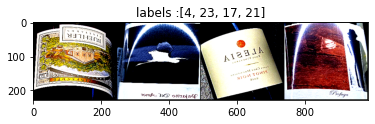

In [10]:
# display sample images 
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds0), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_ds0[i][0] for i in rnd_inds]
y_grid = [train_ds0[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [11]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [12]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [13]:
# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [14]:
# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [15]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [16]:
# definc the training parameters
params_train = {
    'num_epochs':60,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [17]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
model = resnet152().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)

# definc the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 3.250221, val loss: 3.700465, accuracy: 9.20, time: 8.6642 min
----------
Epoch 1/99, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 2.515371, val loss: 2.459506, accuracy: 27.20, time: 17.1060 min
----------
Epoch 2/99, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.919993, val loss: 1.715690, accuracy: 32.40, time: 26.2662 min
----------
Epoch 3/99, current lr=0.001
train loss: 1.682764, val loss: 2.020972, accuracy: 33.20, time: 35.8420 min
----------
Epoch 4/99, current lr=0.001
train loss: 1.347971, val loss: 2.214178, accuracy: 37.20, time: 44.6354 min
----------
Epoch 5/99, current lr=0.001
train loss: 1.163291, val loss: 1.716804, accuracy: 45.20, time: 52.8153 min
----------
Epoch 6/99, current lr=0.001
train loss: 1.060780, val loss: 1.806161, accuracy: 42.40, time: 60.4220 min
----------
Epoch 7/99, current lr=0.001
Copied best model w

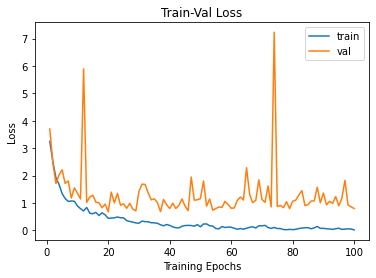

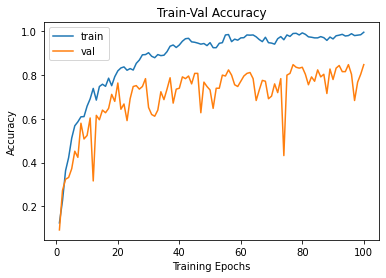

In [19]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [21]:
model = resnet50().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)

# definc the training parameters
params_train = {
    'num_epochs':60,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights_50.pt',
}

model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/59, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 2.950252, val loss: 3.599500, accuracy: 18.40, time: 7.6127 min
----------
Epoch 1/59, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.726013, val loss: 3.026936, accuracy: 35.60, time: 15.1978 min
----------
Epoch 2/59, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.356450, val loss: 1.583348, accuracy: 51.20, time: 22.9560 min
----------
Epoch 3/59, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.162191, val loss: 1.568652, accuracy: 50.40, time: 31.0360 min
----------
Epoch 4/59, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.152523, val loss: 1.448388, accuracy: 55.60, time: 38.5712 min
----------
Epoch 5/59, current lr=0.001
train loss: 0.930682, val loss: 1.637952, accuracy: 45.60, time: 46.2144 min
----------
Epoch 6/59, current lr=0.001
train loss: 0.844407, val loss: 2.394070, acc

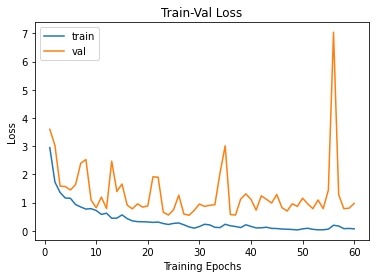

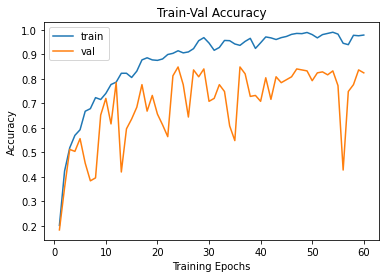

In [22]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()